In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt, seaborn
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

In [3]:
train = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/sales_train.csv')
shop = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/shops.csv')
item = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/items.csv')
itemc = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/item_categories.csv')
test = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/test.csv')

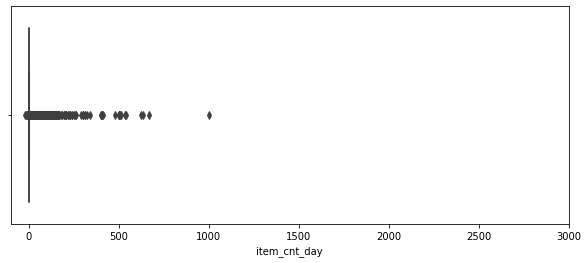

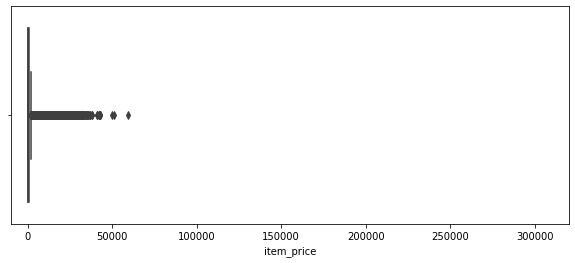

In [4]:
#date is changed from day.month.year to year-month-day 
train['date'] = pd.to_datetime(train['date'], format = '%d.%m.%Y')
train['year'] = train['date_block_num'].apply(lambda x: ((x//12) + 2013))
train['month'] = train['date_block_num'].apply(lambda x: ((x+1) % 12))

#delete outliers
train = train[train['item_cnt_day'] < 1001]
train = train[train['item_price'] < 300000]

#plot train data after delete outliers 
plt.figure(figsize=(10,4))
plt.xlim(-100,3000)
sns.boxplot(x=train['item_cnt_day'])

plt.figure(figsize=(10,4))
plt.xlim(-10000,320000)
sns.boxplot(x=train['item_price'])

#The data has item_price value less than zero, it's incorrect. We make item_price be median.
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train['item_price']<0,'item_price'] = median

In [5]:
train = train.groupby(['shop_id', 'item_id', 'date_block_num','year','month'])['item_cnt_day'].sum().rename('item_cnt_month').reset_index()
train

,shop_id,item_id,date_block_num,year,month,item_cnt_month
0,0,30,1,2013,2,31.0
1,0,31,1,2013,2,11.0
2,0,32,0,2013,1,6.0
3,0,32,1,2013,2,10.0
4,0,33,0,2013,1,3.0
...,...,...,...,...,...,...
1609118,59,22164,27,2015,4,2.0
1609119,59,22164,30,2015,7,1.0
1609120,59,22167,9,2013,10,1.0
1609121,59,22167,11,2013,0,2.0


In [6]:
selected_features = ['shop_id', 'item_id']
X_train = train[selected_features]
X_test = test[selected_features]
y_train = train['item_cnt_month']

from sklearn.ensemble import GradientBoostingRegressor
rfr = GradientBoostingRegressor()
reg=rfr.fit(X_train, y_train)

from math import sqrt
from sklearn.metrics import mean_squared_error
num = sqrt(mean_squared_error(y_train, reg.predict(X_train)))
print(num)
test1 = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/test.csv')
rfr_y_predict2 = rfr.predict(X_test)

rfr_submission = pd.DataFrame({'ID': test1['ID'], 'item_cnt_month': rfr_y_predict2})
rfr_submission.to_csv('/content/gdrive/MyDrive/Colab Notebooks/gbr_submission.csv', index=False,sep=',')

7.170698726535353


In [7]:
dd = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/gbr_submission.csv')
dd

,ID,item_cnt_month
0,0,2.016594
1,1,2.016594
2,2,2.016594
3,3,2.016594
4,4,2.016594
...,...,...
214195,214195,1.437929
214196,214196,1.590547
214197,214197,1.590547
214198,214198,1.437929


In [8]:
del test['ID']
test['date_block_num'] = 34
test['year'] = 2015
test['month'] = 11
test = test[['shop_id','item_id','date_block_num','year','month']]
test 

,shop_id,item_id,date_block_num,year,month
0,5,5037,34,2015,11
1,5,5320,34,2015,11
2,5,5233,34,2015,11
3,5,5232,34,2015,11
4,5,5268,34,2015,11
...,...,...,...,...,...
214195,45,18454,34,2015,11
214196,45,16188,34,2015,11
214197,45,15757,34,2015,11
214198,45,19648,34,2015,11


In [9]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from keras.models import Sequential
from keras.layers import LSTM, Dense, Activation, ThresholdedReLU, MaxPooling2D, Embedding, Dropout
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from keras import backend as K
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler
import gc

In [11]:
X_train = train[train.date_block_num < 33].drop(['item_cnt_month'], axis=1)
X_train = np.expand_dims(train.values[:, :-1], axis=2)
Y_train = train[train.date_block_num < 33]['item_cnt_month']
Y_train = train.values[:, -1:]
X_valid = train[train.date_block_num == 33].drop(['item_cnt_month'], axis=1)
X_valid = np.expand_dims(train.values[:, :-1], axis=2)
Y_valid = train[train.date_block_num == 33]['item_cnt_month']
Y_valid = train.values[:, -1:]
X_test = test
X_test = np.expand_dims(test.values[:, :], axis=2)

In [12]:
K.clear_session()
model_lstm = Sequential()
model_lstm.add(LSTM(16, input_shape=(5,1),return_sequences=True))
model_lstm.add(Dropout(0.5))
model_lstm.add(LSTM(32))
model_lstm.add(Dropout(0.5))
model_lstm.add(Dense(8))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer="adam", loss='mse', metrics=["mse"])
print(model_lstm.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5, 16)             1152      
                                                                 
 dropout (Dropout)           (None, 5, 16)             0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                6272      
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 8)                 264       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 7,697
Trainable params: 7,697
Non-trainabl

Epoch 1/20
786/786 [==============================] - 89s 107ms/step - loss: 71.9249 - mse: 71.9249 - val_loss: 71.6543 - val_mse: 71.6543
Epoch 2/20
786/786 [==============================] - 65s 82ms/step - loss: 71.7286 - mse: 71.7286 - val_loss: 71.6476 - val_mse: 71.6476
Epoch 3/20
786/786 [==============================] - 59s 75ms/step - loss: 71.6857 - mse: 71.6857 - val_loss: 71.6461 - val_mse: 71.6461
Epoch 4/20
786/786 [==============================] - 59s 75ms/step - loss: 71.6580 - mse: 71.6580 - val_loss: 71.6399 - val_mse: 71.6399
Epoch 5/20
786/786 [==============================] - 57s 73ms/step - loss: 71.6531 - mse: 71.6531 - val_loss: 71.6364 - val_mse: 71.6364
Epoch 6/20
786/786 [==============================] - 57s 73ms/step - loss: 71.6488 - mse: 71.6488 - val_loss: 71.6362 - val_mse: 71.6362
Epoch 7/20
786/786 [==============================] - 58s 74ms/step - loss: 71.6445 - mse: 71.6445 - val_loss: 71.6337 - val_mse: 71.6337
Epoch 8/20
786/786 [=============

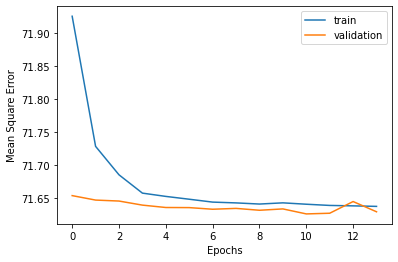

<Figure size 432x288 with 0 Axes>

In [13]:
LSTM_PARAM = {"batch_size":2048,
              "verbose":1,
              "epochs":20}

    
callbacks_list=[EarlyStopping(monitor="val_loss",min_delta=.001, patience=3,mode='auto')]
hist = model_lstm.fit(X_train, Y_train,validation_data=(X_valid, Y_valid),callbacks=callbacks_list, **LSTM_PARAM)
pred = model_lstm.predict(X_test)

# Model Evaluation
best = np.argmin(hist.history["val_loss"])
print("Optimal Epoch: {}",best)
print("Train Score: {}, Validation Score: {}".format(hist.history["loss"][best],hist.history["val_loss"][best]))

plt.plot(hist.history['loss'], label='train')
plt.plot(hist.history['val_loss'], label='validation')
plt.xlabel("Epochs")
plt.ylabel("Mean Square Error")
plt.legend()
plt.show()
plt.savefig("Train and Validation MSE Progression3.png")

In [14]:
submission = pd.DataFrame(pred,columns=['item_cnt_month'])
submission.to_csv('/content/gdrive/MyDrive/Colab Notebooks/lstm_sub3.csv',index_label='ID')

In [15]:
df = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/lstm_sub3.csv')
df

,ID,item_cnt_month
0,0,2.023364
1,1,2.023364
2,2,2.023364
3,3,2.023364
4,4,2.023364
...,...,...
214195,214195,2.274089
214196,214196,2.274089
214197,214197,2.274089
214198,214198,2.274089


In [16]:
from xgboost import XGBRegressor
from xgboost import plot_importance
import time

In [17]:
X_train = train[train.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = train[train.date_block_num < 33]['item_cnt_month']
X_valid = train[train.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = train[train.date_block_num == 33]['item_cnt_month']
X_test = test

In [ ]:
ts = time.time()

model = XGBRegressor(
    max_depth=8,
    n_estimators=1000,
    min_child_weight=300, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=20)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[13:36:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:8.40506	validation_1-rmse:7.01916
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:8.37681	validation_1-rmse:6.96663
[2]	validation_0-rmse:8.19193	validation_1-rmse:6.74313
[3]	validation_0-rmse:8.0053	validation_1-rmse:6.53812
[4]	validation_0-rmse:7.98466	validation_1-rmse:6.50774
[5]	validation_0-rmse:7.9675	validation_1-rmse:6.48871
[6]	validation_0-rmse:7.95294	validation_1-rmse:6.47663
[7]	validation_0-rmse:7.81671	validation_1-rmse:6.38913
[8]	validation_0-rmse:7.69009	validation_1-rmse:6.26583
[9]	validation_0-rmse:7.68061	validation_1-rmse:6.2524
[10]	validation_0-rmse:7.58461	validation_1-rmse:6.19255
[11]	validation_0-rmse:7.57723	validation_1-rmse:6.1897
[12]	validation_0-rmse:7.49915	validation_1-

In [ ]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('/content/gdrive/MyDrive/Colab Notebooks/xgb_submission3.csv', index=False)

In [ ]:
dl = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/xgb_submission3.csv')
dl